## Load Libraries

In [21]:
import time

# Linear Algebra
import numpy as np

# Data Processing
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Stats
from scipy import stats

# Algorithms
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, classification_report, roc_auc_score, roc_curve,confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# String matching
import difflib

# Set random seed for reproducibility
np.random.seed(0)

# Stop unnecessary Seaborn warnings
import warnings
warnings.filterwarnings('ignore')
sns.set()  # Stylises graphs
plt.style.use('seaborn-whitegrid')

## Load Data

In [2]:
df = pd.read_csv(r'C:\Users\Vivek 6666\Downloads\advertising.csv')

## Examine the data

In [3]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


## Building Models on Data
### Prepping the Data
We shall first encode a few of our variables and create out test and validation data.

In [4]:
X = df.copy()

drop_cols = ['Ad Topic Line', 'City', 'Timestamp']

for col in drop_cols:
    X.drop([col], axis=1, inplace=True)

In [5]:
encode_cols = ['Country']
le = LabelEncoder()

for col in encode_cols:
    X[col] = le.fit_transform(X[col])

In [6]:
y = X['Clicked on Ad']
X.drop(['Clicked on Ad'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=0)

print(f'X Train Shape: {X_train.shape}')
print(f'X Validation Shape: {X_valid.shape}')
print(f'y Train Shape: {y_train.shape}')
print(f'y Validation Shape: {y_valid.shape}')

X Train Shape: (800, 6)
X Validation Shape: (200, 6)
y Train Shape: (800,)
y Validation Shape: (200,)


## Modelling with Random Forests

In [7]:
scores = {}

for n_estimators in range(2, 100):
    RF_model = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    RF_model.fit(X_train, y_train)
    RF_predictions = RF_model.predict(X_valid)
    RF_mae = mean_absolute_error(RF_predictions, y_valid)
    scores[n_estimators] = RF_mae

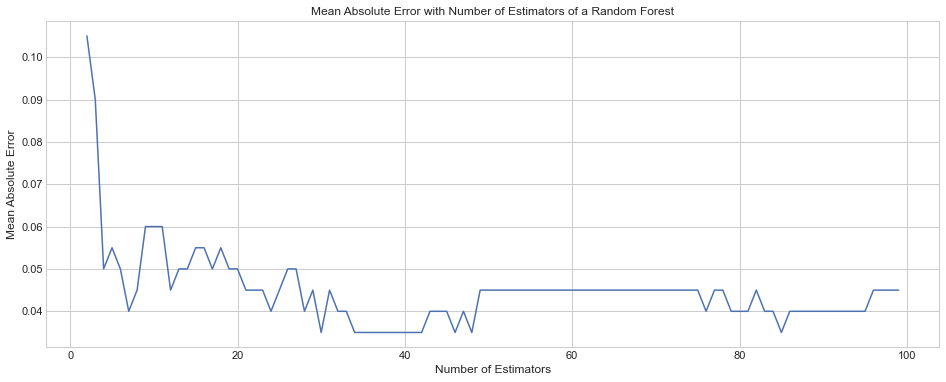

In [26]:
plt.figure(figsize=(16, 6))
plt.title("Mean Absolute Error with Number of Estimators of a Random Forest")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Absolute Error")
plt.plot(scores.keys(), scores.values())
plt.show()

In [9]:
best_n_estimators = []

for n_estimators, score in scores.items():
    if score == min(scores.values()):
        best_n_estimators.append(n_estimators)

print(f"Best Number of Estimators: {min(best_n_estimators)}")

Best Number of Estimators: 30


This shows that we get high accuracy with just five estimators in our random forest.



In [10]:
rf_clf = RandomForestClassifier(n_estimators=min(best_n_estimators), random_state=0)

rf_time = time.time()
rf_clf.fit(X_train, y_train)
rf_time = time.time() - rf_time

rf_auc = roc_auc_score(y_valid, rf_clf.predict(X_valid))

score_train = rf_clf.score(X_train, y_train)
print('Training Accuracy : ' + str(score_train))

score_valid = rf_clf.score(X_valid, y_valid)
print('Validation Accuracy : ' + str(score_valid))

print()
print(f'AUC: {rf_auc}')
print(f'Time Elapsed: {rf_time} seconds')
print(classification_report(y_valid, rf_clf.predict(X_valid)))

Training Accuracy : 1.0
Validation Accuracy : 0.965

AUC: 0.9635668276972624
Time Elapsed: 0.14396142959594727 seconds
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       108
           1       0.98      0.95      0.96        92

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



- With this, it seems that this model **95%** of the time prediected if a person would not click on an ad and 96% of the time predicted a person would click on an ad.

- We can try to do better than this though.

## Random Forest Variable Importances

In [11]:
columns = X.columns
train = pd.DataFrame(np.atleast_2d(X_train), columns=columns)

In [12]:
feature_importances = pd.DataFrame(rf_clf.feature_importances_,index = train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances.head(10)

,index,importance
0,Daily Internet Usage,0.424082
1,Daily Time Spent on Site,0.313278
2,Area Income,0.141775
3,Age,0.092096
4,Country,0.025493
5,Male,0.003275


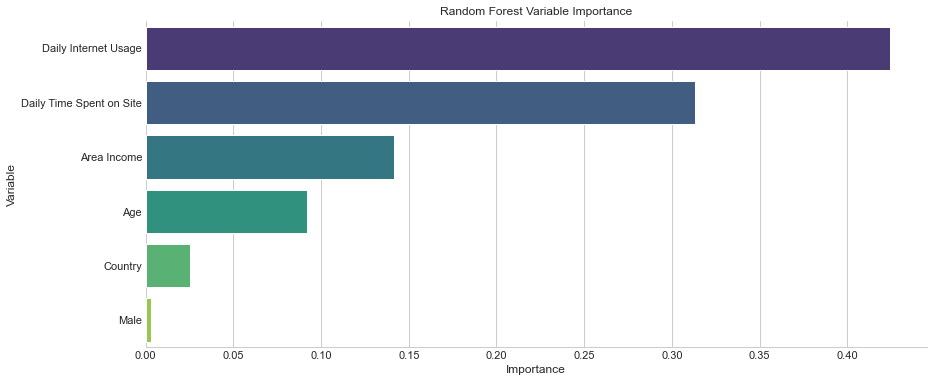

In [28]:
plt.figure(figsize=(14, 6))
sns.barplot(
    x="importance", y='index',
    data=feature_importances[0:10], label="Total",palette='viridis')
plt.title("Random Forest Variable Importance")
plt.ylabel("Variable")
plt.xlabel("Importance")
sns.despine(left=True)
plt.show()

## Linear Support Vector Classification

In [14]:
svc_lin_scores = {}
c = np.linspace(0.0069, 0.0072, 10)

for C in c:
    svc_lin_clf = SVC(random_state=0, kernel='linear', C=C)
    svc_lin_clf.fit(X_train, y_train)
    svc_lin_scores[C] = svc_lin_clf.score(X_train, y_train)

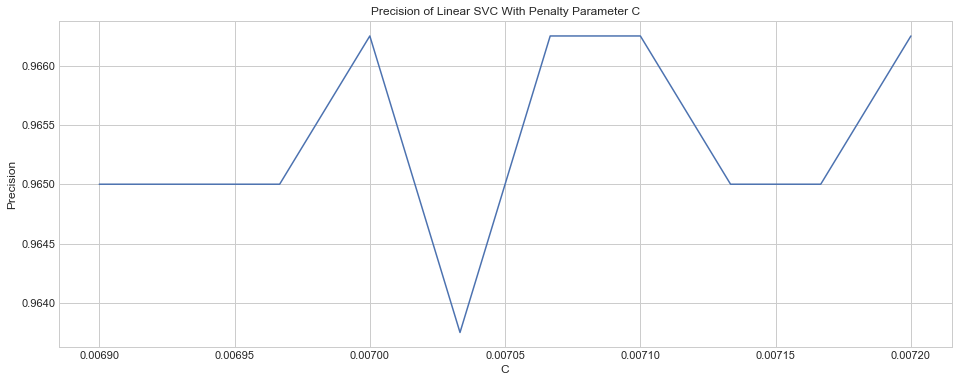

In [15]:
plt.figure(figsize=(16, 6))

plt.title("Precision of Linear SVC With Penalty Parameter C")
plt.ylabel("Precision")
plt.xlabel("C")
plt.plot(svc_lin_scores.keys(), svc_lin_scores.values())
plt.show()

In [16]:
svc_lin_clf = SVC(random_state=0, kernel='linear', C=0.007, probability=True)

svc_lin_time = time.time()
svc_lin_clf.fit(X_train, y_train)
svc_lin_time = time.time() - svc_lin_time

svc_lin_auc = roc_auc_score(y_valid, svc_lin_clf.predict(X_valid))

score_train = svc_lin_clf.score(X_train, y_train)
print('Training Accuracy : ' + str(score_train))

score_valid = svc_lin_clf.score(X_valid, y_valid)
print('Validation Accuracy : ' + str(score_valid))

print()
print(f'AUC: {svc_lin_auc}')
print(f'Time Elapsed: {svc_lin_time} seconds')
print(classification_report(y_valid, svc_lin_clf.predict(X_valid)))

Training Accuracy : 0.96625
Validation Accuracy : 0.965

AUC: 0.9651771336553946
Time Elapsed: 41.59000873565674 seconds
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       108
           1       0.96      0.97      0.96        92

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



- This seems like this is as good as the classifier will get without **overfitting.** 

- The only parameter we can tune in a linear SVC is the penalty parameter C. 

- Degree only applies to a poly Kernal, and γ  only applies to non-linear hyperplanes.

## K Nearest Neighbors

In [17]:
knn_scores = {}

for k in range(1, 30):
    knn_clf = KNeighborsClassifier(k)
    knn_clf.fit(X_train, y_train)
    knn_scores[k] = knn_clf.score(X_train, y_train)

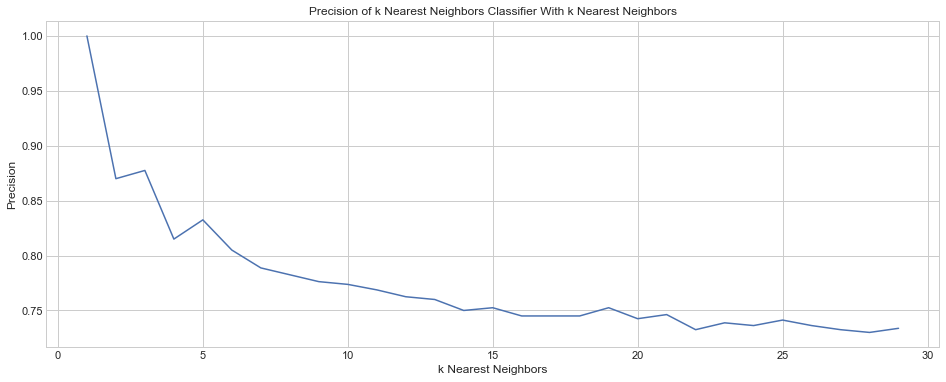

In [18]:
plt.figure(figsize=(16, 6))
plt.title("Precision of k Nearest Neighbors Classifier With k Nearest Neighbors")
plt.ylabel("Precision")
plt.xlabel("k Nearest Neighbors")
plt.plot(knn_scores.keys(), knn_scores.values())
plt.show()

- Looking at the graph, it would seem that 1-nearest neighbour would be the best.
- This might lead to **overfitting**, however. 
- For more generalised datasets, it would seem that 3-nearest neighbours would be a safer bet.

In [19]:
knn_clf = KNeighborsClassifier(3)

knn_time = time.time()
knn_clf.fit(X_train, y_train)
knn_time = time.time() - knn_time

knn_auc = roc_auc_score(y_valid, knn_clf.predict(X_valid))

score_train = knn_clf.score(X_train, y_train)
print('Training Accuracy : ' + str(score_train))

score_valid = knn_clf.score(X_valid, y_valid)
print('Validation Accuracy : ' + str(score_valid))

print()
print(f'AUC: {knn_auc}')
print(f'Time Elapsed: {knn_time} seconds')
print(classification_report(y_valid, knn_clf.predict(X_valid)))

Training Accuracy : 0.8775
Validation Accuracy : 0.685

AUC: 0.6849838969404186
Time Elapsed: 0.0 seconds
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       108
           1       0.65      0.68      0.67        92

    accuracy                           0.69       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.69      0.69      0.69       200



#### This is not anywhere near as good as the random forest or support vector classifier from before!

## Comparing Models

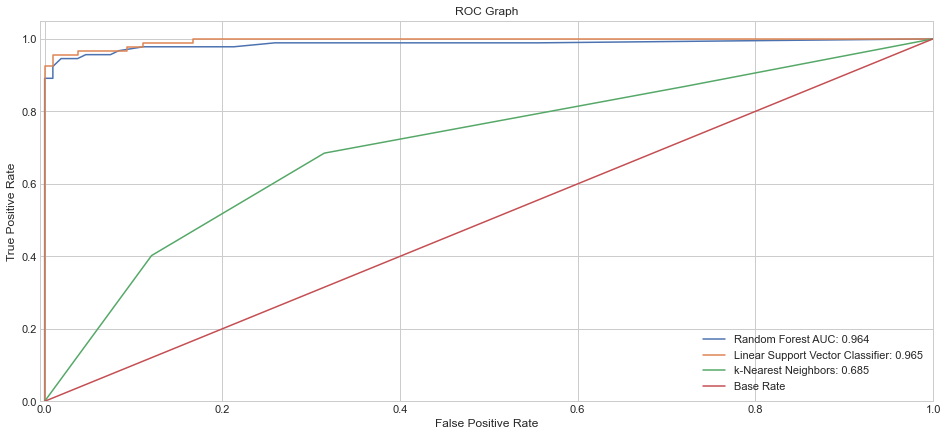

In [30]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_valid, rf_clf.predict_proba(X_valid)[:,1])
svc_lin_fpr, svc_lin_tpr, svc_lin_thresholds = roc_curve(y_valid, svc_lin_clf.predict_proba(X_valid)[:,1])
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_valid, knn_clf.predict_proba(X_valid)[:,1])

plt.figure(figsize=(16, 7))

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest AUC: {round(rf_auc, 3)}')
plt.plot(svc_lin_fpr, svc_lin_tpr, label=f'Linear Support Vector Classifier: {round(svc_lin_auc, 3)}')
plt.plot(knn_fpr, knn_tpr, label=f'k-Nearest Neighbors: {round(knn_auc, 3)}')

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

## Modelling Conclusions
- Whilst the random forest could have been tuned. Further, it had good precision. 

- It did not take too much time to fit the model, which would allow for fast tuning of parameters. 

- The linear kernel SVC took a very long time to provide the data.

- It is shorter at predicting than the random forest and k nearest neighbours classifiers. 

- This time taken to fit the data is mitigated, as only one parameter must be tuned. The k Nearest Neighbors performed the worst in AUC and prediction time. This was not a good model for this data.

- In the end, the linear SVC should be used as it had a slightly higher AUC and faster prediction time when compared to the random forest. 

- The end accuracy of this project is ```95.4%.``` This is not anywhere near as good as the random forest or support vector classifier from before!